## LangGraph
* LangGraph is a stateful, orchestration framework for complex agentic systems and is more low-level and controllable.
* LangGraph is an MIT licensed Open-source library 

## LangSmith
* It is uses to inspect, monitor and evaluate your chains, so that you can continuously optimize and deploy with confidence.


## LangGraph Platform
* `LangGraph platform` is service for deploying and scaling LangGraph applications, with a built-in studio for prototyping, debugging, and sharing LangGraph applications.
* `LangGraph Platform` is proprietary software that will eventually be a paid service for certain tiers of usage.

What is Agent?
Agent control flow defined by an LLM.


* LangGraph help to build agents to maintain the application reliability even if you push out the level of control give to LLM.

### LangGraph Pillars:
* Persistence
* Streaming
* Human-in-the-loop
* Controllability

## 1.1 Simple Graph

Create a simple graph with 3 nodes and 1 conditional edge using LangGraph.

![alt text](images/simple.png)

In [1]:
from typing import TypedDict

## Define state of the graph
class State(TypedDict):
    graph_state: str


## Define nodes (python funcitons). Each node operates on the state.
def node_1(state):
    print("-------Node1----------")
    return {"graph_state": state['graph_state']+" I am"}
    
def node_2(state):
    print("-------Node2----------")
    return {"graph_state": state['graph_state']+" happy!"}

def node_3(state):
    print("-------Node3----------")
    return {"graph_state": state['graph_state']+" sad!"}

#### Edges
* `Normal Edges` simply connect the nodes, if you want to always go from
* `Conditional Edges` used to optionally route between nodes.
* `conditional edge` is implemented as a function that returns the next node to visit based upon some logic.

In [ ]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # use state to decide on the next node to visit
    user_input = state["graph_state"]

    if random.random() < 0.5:

        # 50% of time, return Node2
        return "node_2"
    
    # 50% of time, return Node3
    return "node_3"

#### Graph Construction
* Initialize `StateGraph` with `State` class we defined above
* Add nodes and edges
* use `START` node that sends user input to graph, and it indicate where to start graph.
* use `END` node that represents a terminate node
* Compile graph to perform few basic checks about the structure of your graph.

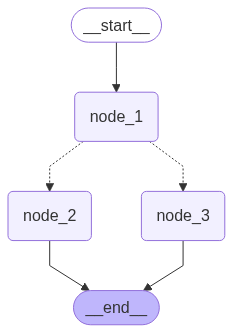

In [9]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

builder = StateGraph(State)

# add nodes
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# graph compile
graph = builder.compile()

# view
display(Image(graph.get_graph().draw_mermaid_png()))

#### Graph Invocation
* `Compiled Graph` implements the runnable protocol
* The `ìnvoke` is one of the standard methods in this interface.
* The input is a dictionary `{"graph_state": "Hi, this is lance."}`, which sets the initial value for our graph state dict.


In [16]:
graph.invoke({"graph_state": "Hi, this is Lance."})

-------Node1----------
-------Node2----------


{'graph_state': 'Hi, this is Lance. I am happy!'}

## 1.2 Chain
Create a simple graph with chain of `chat messages`, `chat models`, `binding tools`, and `execute tool calls` in graph. 

### Messages
* Chat model can use `messages`, which capture different roles within a conversation.
* LangChain support various message types, including `HumanMessage`, `AIMessage`, `Systemmessage` and `ToolMessage`.
* These represent a message from the user, from chat model, for the chat model to instruct behavior and from a tool call.
* Each message can be supplied with few things:
    * ``content`` - content of the mesage
    * ``name`` - optionally, who is creating the message
    * ``response_metadata`` - optionally, a dict of metadata that is often specific to each model provider 

In [7]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

messages = [AIMessage(content="so you said you were researching ocean mammals", name="model")]
messages.extend([HumanMessage(content="yes, that's right.", name="Lance")])
messages.extend([AIMessage(content="Great, what would you like to learn about.", name="model")])
messages.extend([HumanMessage(content="I want to learn about the best place to see Orcas in US", name="Lance")])

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: model

so you said you were researching ocean mammals
================================ Human Message =================================
Name: Lance

yes, that's right.
================================== Ai Message ==================================
Name: model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in US


In [8]:
import os
from dotenv import load_dotenv

# Load the environment variables from .env file
load_dotenv()

# Fetch the API key
api_key = os.getenv("OPENAI_API_KEY")


In [9]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0, 
)
result = llm.invoke(messages)
print(result)

content="One of the best places to see orcas in the U.S. is the Pacific Northwest, particularly around the San Juan Islands in Washington State. Here are some key spots:\n\n1. **San Juan Islands**: This archipelago is famous for orca sightings, especially the Southern Resident orcas. Whale watching tours operate from several locations, including Friday Harbor and Roche Harbor.\n\n2. **Puget Sound**: Orcas can often be spotted in the waters of Puget Sound, especially during the summer months when they are more active and feeding.\n\n3. **Victoria, British Columbia**: While technically in Canada, it's very close to the U.S. border and is a popular spot for whale watching tours that often see orcas.\n\n4. **Olympic National Park**: The coastal waters around this national park can also be a good place to spot orcas, particularly from the shore or on boat tours.\n\n5. **Maui, Hawaii**: While not as common as in the Pacific Northwest, orcas have been spotted in Hawaiian waters, particularly 

In [10]:
result.response_metadata

{'token_usage': {'completion_tokens': 248,
  'prompt_tokens': 62,
  'total_tokens': 310,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_54eb4bd693',
 'id': 'chatcmpl-Bb73TlRaMXJowcTfWthZxCgoqttfm',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

### Tools
* ``Tools`` are needed whenever you want a model to control of your code or call any external APIs.
* Many LLM providers support tool calling
* You can specify python function into `ChatModel.bind_tools()`

In [11]:
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# Tools creation
tools =[multiply]

# Tool binding
llm_with_tools = llm.bind_tools(tools)

# Tool calling
response = llm_with_tools.invoke([HumanMessage(content="what is 2 multipled by 3", name="bob")])
response


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nriMaJ0nGtyZc6Ca1IIIECLx', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 63, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_54eb4bd693', 'id': 'chatcmpl-Bb73eeLAommH2Af0i8irifBO12RMC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--637e1da9-97b3-4a25-b0fe-d0087fe2e443-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_nriMaJ0nGtyZc6Ca1IIIECLx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 63, 'output_tokens': 17, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cach

In [12]:
response.additional_kwargs['tool_calls']

[{'id': 'call_nriMaJ0nGtyZc6Ca1IIIECLx',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

In [13]:
response.response_metadata['token_usage']

{'completion_tokens': 17,
 'prompt_tokens': 63,
 'total_tokens': 80,
 'completion_tokens_details': {'accepted_prediction_tokens': 0,
  'audio_tokens': 0,
  'reasoning_tokens': 0,
  'rejected_prediction_tokens': 0},
 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}

### Messages as State
* You can define state using `MessageState`.

In [14]:
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

* LangGraph has a pre-built `MessageState` Class
    * with a pre-build single `message` key.
    * which is a list of `AnyMessage` objects and uses the `add_messages` reducer.

In [15]:
from langgraph.graph import MessagesState

class State(MessagesState):
    pass

### Build Graph
Create a graph with chain of `chat Messages`, `Chat Model`, `Message State`, `Binding Tools`, and `Execute tools`. 

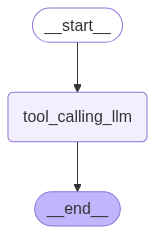

In [5]:
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState, StateGraph, START, END

# define node
def tool_calling_node(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_node)

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()

# view graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
graph.invoke({"messages": [HumanMessage(content="Hi", name="nancy")]})

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, name='nancy', id='f2d8e83c-0571-45e2-a308-859c7bdec676'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 55, 'total_tokens': 65, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_54eb4bd693', 'id': 'chatcmpl-Bb73vop2AXGmLzUwERPYegTyRyI6R', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--9e2e2215-2e22-4530-a884-c743b555b1c0-0', usage_metadata={'input_tokens': 55, 'output_tokens': 10, 'total_tokens': 65, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [16]:
graph.invoke({"messages": [HumanMessage(content="Multiply 2 and 3", name="nancy")]})

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, name='nancy', id='2fdfe05b-84e2-44e0-821f-76c837e0097e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AJpTiIFXpFmMiHJoruoqZKrW', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 60, 'total_tokens': 77, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_54eb4bd693', 'id': 'chatcmpl-Bb74si157fkbxflkXHUfd2WJDGt1u', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--eb1dd4cf-beaf-4b93-a83f-9102784b4d66-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_AJpTiIFXp

## 1.3 Router

Router where the chat model routes between a direct llm response or tool call based upon the user input.

* The `ToolNode` is built-in Class to simply pass a list of tools to initialize it.
* The `tool_condition` is built-in function which use as conditional edge

In [27]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState, StateGraph, START, END

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0, 
)

# Define tool
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# Bind tools
llm_with_tools = llm.bind_tools([multiply])


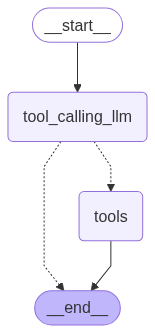

In [22]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define node
def tool_calling_node(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("tool_calling_llm", tool_calling_node)
builder.add_node("tools", ToolNode([multiply]))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)

graph = builder.compile()

# view
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
result = graph.invoke({"messages": [HumanMessage(content="Multiply 3 and 5")]})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 3 and 5
================================== Ai Message ==================================
Tool Calls:
  multiply (call_C5MXnhCEnELzhvJgYg69xGfB)
 Call ID: call_C5MXnhCEnELzhvJgYg69xGfB
  Args:
    a: 3
    b: 5
================================= Tool Message =================================
Name: multiply

15


In [26]:
result = graph.invoke({"messages": [HumanMessage(content="Hi")]})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello! How can I assist you today?


## 1.4 Agent